In [29]:
# additional imports
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler # we can also do /X.max() 
from xgboost import XGBClassifier

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

BASE_PATH = '/content/drive/My Drive/'
PATH_DEV_NODUP = os.path.join(BASE_PATH, 'fer_dev_nodup.csv') 
PATH_PRIVATE_TEST_NO_DUP = os.path.join(BASE_PATH, 'fer_test_nodup.csv')
BALANCED5k_PATH = os.path.join(BASE_PATH, 'balanced5k.csv') # old one
BALANCEDnk_PATH = os.path.join(BASE_PATH, 'balancednk.csv') # 3rd
BALANCED1408_PATH = os.path.join(BASE_PATH, 'balanced_1408.csv') # last

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 0. Let's see the data first

train

In [10]:
balanced1408 = pd.read_csv(BALANCED1408_PATH).drop('Unnamed: 0', axis=1)
balanced1408.emotion.value_counts()

6    5000
5    5000
4    5000
3    5000
2    5000
0    5000
1    2292
Name: emotion, dtype: int64

test, aka dev

In [11]:
dev = pd.read_csv(PATH_DEV_NODUP).drop('Unnamed: 0', axis=1)
X_test, y_test = dev.drop('emotion', axis=1), dev.emotion.values

## 1. Select small balanced chunk of data

Since we can see that label 1 has the least number of smaples, so let's pick maximal balanced chunk according to label 1:

In [12]:
ideal = balanced1408[balanced1408.emotion==1]
for label in [0, 2, 3, 4, 5, 6]:
    new_chunk = balanced1408[balanced1408.emotion == label].sample(balanced1408.emotion.value_counts()[1])
    ideal = ideal.append(new_chunk)

ideal.emotion.value_counts()

6    2292
5    2292
4    2292
3    2292
2    2292
1    2292
0    2292
Name: emotion, dtype: int64

We will use it as train set

In [13]:
X_train, y_train = ideal.drop('emotion', axis=1), ideal.emotion.values

# Basic ML models on small balanced set

## 3. XGB

Accuracy score after XGB with default params on balanced and not scaled data: 0.3753416337686001

Classification report: 
              precision    recall  f1-score   support

           0       0.28      0.17      0.21       435
           1       0.03      0.02      0.03        41
           2       0.24      0.17      0.20       445
           3       0.50      0.54      0.52       865
           4       0.35      0.38      0.36       625
           5       0.38      0.45      0.41       296
           6       0.35      0.42      0.38       586

    accuracy                           0.38      3293
   macro avg       0.30      0.31      0.30      3293
weighted avg       0.36      0.38      0.37      3293




Text(0.5, 1.0, 'Confusion matrix')

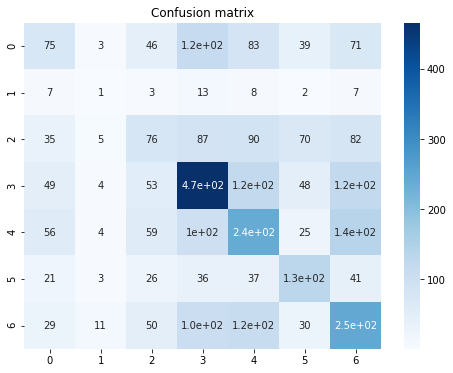

In [22]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(f'Accuracy score after XGB with default params on balanced and not scaled data: \
{accuracy_score(y_test, y_pred_xgb)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_xgb)}\n')
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, 
            cmap='Blues')
plt.title('Confusion matrix')

## 4. RFC

Accuracy score after RFC with default params on balanced and not scaled data: 0.377163680534467

Classification report: 
              precision    recall  f1-score   support

           0       0.28      0.23      0.25       435
           1       0.30      0.22      0.25        41
           2       0.24      0.22      0.23       445
           3       0.53      0.51      0.52       865
           4       0.34      0.39      0.36       625
           5       0.42      0.46      0.44       296
           6       0.35      0.37      0.36       586

    accuracy                           0.38      3293
   macro avg       0.35      0.34      0.34      3293
weighted avg       0.37      0.38      0.38      3293




Text(0.5, 1.0, 'Confusion matrix')

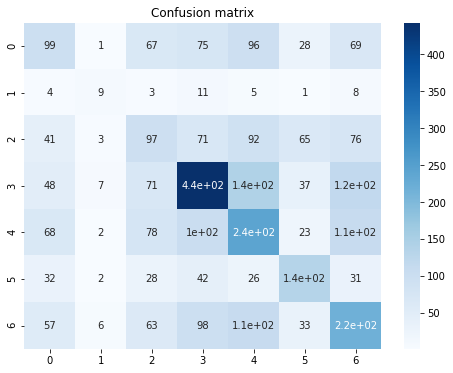

In [23]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print(f'Accuracy score after RFC with default params on balanced and not scaled data: \
{accuracy_score(y_test, y_pred_rfc)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_rfc)}\n')

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc), annot=True, 
            cmap='Blues')
plt.title('Confusion matrix')

OK, not good, so let's take the whole data

# Basic ML on larger data

In [24]:
X_trainb, y_trainb = balanced1408.drop('emotion', axis=1), balanced1408.emotion.values

Accuracy score after RFC with default params on balanced5k.csv and not scaled data: 0.4099605223200729

Classification report: 
              precision    recall  f1-score   support

           0       0.30      0.24      0.27       435
           1       1.00      0.05      0.09        41
           2       0.28      0.26      0.27       445
           3       0.56      0.57      0.56       865
           4       0.37      0.39      0.38       625
           5       0.45      0.53      0.49       296
           6       0.36      0.41      0.39       586

    accuracy                           0.41      3293
   macro avg       0.48      0.35      0.35      3293
weighted avg       0.41      0.41      0.40      3293




Text(0.5, 1.0, 'Confusion matrix')

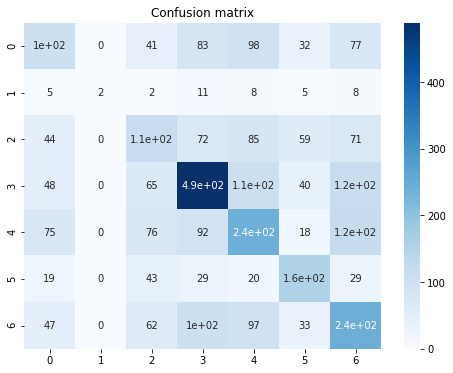

In [25]:
rfcb = RandomForestClassifier()
rfcb.fit(X_trainb, y_trainb)
y_pred_rfcb = rfcb.predict(X_test)
print(f'Accuracy score after RFC with default params on balanced5k.csv and not scaled data: \
{accuracy_score(y_test, y_pred_rfcb)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_rfcb)}\n')
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rfcb), annot=True, 
            cmap='Blues')
plt.title('Confusion matrix')

Accuracy score after XGB with default params on balanced5k.csv and not scaled data: 0.38505921651989067

Classification report: 
              precision    recall  f1-score   support

           0       0.30      0.19      0.23       435
           1       0.00      0.00      0.00        41
           2       0.25      0.16      0.19       445
           3       0.52      0.57      0.54       865
           4       0.34      0.38      0.36       625
           5       0.38      0.46      0.41       296
           6       0.34      0.43      0.38       586

    accuracy                           0.39      3293
   macro avg       0.30      0.31      0.30      3293
weighted avg       0.37      0.39      0.37      3293




Text(0.5, 1.0, 'Confusion matrix')

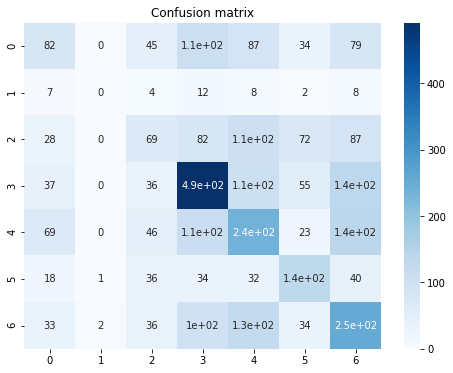

In [26]:
xgbb = XGBClassifier()
xgbb.fit(X_trainb, y_trainb)
y_pred_xgbb = xgbb.predict(X_test)
print(f'Accuracy score after XGB with default params on balanced5k.csv and not scaled data: \
{accuracy_score(y_test, y_pred_xgbb)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_xgbb)}\n')
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgbb), annot=True, 
            cmap='Blues')
plt.title('Confusion matrix')

Okay then, let's save the best model and test it on PrivateTest. RFC reached rather good accuracy on larger data, so we will select this model

# Saving the model

In [27]:
import joblib

filename = 'fer_best_ml_model.sav'
joblib.dump(rfcb, filename)

['fer_best_ml_model.sav']

# Test on Private Test

Anyone can just take the model and check it on some set

In [30]:
# we will test our model on this new data it has never 'seen'
private_test = pd.read_csv(PATH_PRIVATE_TEST_NO_DUP).drop('Unnamed: 0', axis=1)
X_pt, y_pt = private_test.drop('emotion', axis=1), private_test.emotion.values

In [31]:
# load the model & see the results :) 
loaded_model = joblib.load(filename)
result = loaded_model.score(X_pt, y_pt)
print(f'The accuracy of RFC on private test: {result}')

The accuracy of RFC on private test: 0.41003671970624234
